In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Typhoid_2-21-2021.csv')
df.head()

# Preprocessing
df['AGE'] = df['AGE'].str.extract('(\d+)').astype(float)
df['GENDER'] = df['GENDER'].map({'Male': 0, 'Female': 1})
df['RESULT_TEXT'] = df['RESULT_TEXT'].map({'NEGATIVE': 0, 'POSITIVE': 1})

# Handle missing values
imputer = SimpleImputer(strategy='mean')
df[['AGE', 'GENDER']] = imputer.fit_transform(df[['AGE', 'GENDER']])

# Feature Engineering
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=[0, 18, 35, 50, 100], labels=['0-18', '19-35', '36-50', '51+'])
features = ['AGE', 'GENDER', 'AGE_GROUP']
X = df[features]

# Encode categorical feature 'AGE_GROUP'
label_encoder = LabelEncoder()
X.loc[:, 'AGE_GROUP'] = label_encoder.fit_transform(X['AGE_GROUP'])

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=10), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, df['RESULT_TEXT'])

# Use the best parameters
best_params = grid_search.best_params_
clf = RandomForestClassifier(**best_params, random_state=10)

# Additional Data Preprocessing
scaler = StandardScaler()
X[['AGE']] = scaler.fit_transform(X[['AGE']])

# Handling Class Imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, df['RESULT_TEXT'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
classification_rep = classification_report(y_test, y_pred)

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print('Classification Report:\n', classification_rep)

# ... (the rest of the code for visualizations remains unchanged)


/Users/deepesh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
# Load the dataset
df = pd.read_csv('Typhoid_2-21-2021.csv')
df.head()



Unnamed: 0      SECTION_NO            MRNO     PATIENT_NAME  \
0           1  K04MIC17123950  K0460000001366       Sonia Khan   
1           2  K04MIC17123950  K0460000001366       Sonia Khan   
2           3  K04MIC18011045  K0460000001388        Aurangzeb   
3           4  K04MIC17048512  K0460000001390    Muhammad Raza   
4           5  K04MIC19121433  K0460000001408  Muhammad Shafiq   

           FATHER_NAME HUSBAND_NAME       NIC_NEW REFERRED_FROM         AGE  \
0  MUHAMMAD AKBAR KHAN          NaN  1.310187e+12           NaN  33 Year(s)   
1  MUHAMMAD AKBAR KHAN          NaN  1.310187e+12           NaN  33 Year(s)   
2           NADIR KHAN          NaN  1.310163e+12           NaN  52 Year(s)   
3     MUHAMMAD RAFIQUE          NaN  1.310169e+12           NaN  31 Year(s)   
4            ALI ZAMAN          NaN  1.310164e+12           NaN  36 Year(s)   

   GENDER  NO_OF_ADMISSION    DISTRICT      TEHSIL            REPORT_VERIFIED  \
0  Female                0  Abbottabad  Abbottabad  10/7/2017 10:05:16 A10P10   
1  Female                0  Abbottabad  Abbottabad  10/7/2017 10:05:13 A10P10   
2    Male                0    Mansehra    Mansehra    1/23/2018 11:15:40 A1P1   
3    Male                0  Abbottabad  Abbottabad      5/2/2017 9:20:21 A5P5   
4    Male                0  Abbottabad  Abbottabad    8/21/2019 15:51:51 A8P8   

             CPT_ID RESULT_VALUE          CPT_ID.1    SECTION_NO.1 RESULT_TEXT  
0  1000000000086677            Y  1000000000084517  K04MIC17123950    NEGATIVE  
1  1000000000084517            Y  1000000000084517  K04MIC17123950    NEGATIVE  
2  1000000000084517            Y  1000000000084517  K04MIC18011045    NEGATIVE  
3  1000000000084517            Y  1000000000084517  K04MIC17048512    POSITIVE  
4  1000000000086677            Y  1000000000084517  K04MIC19121433    NEGATIVE

In [4]:
# Preprocessing
df['AGE'] = df['AGE'].str.extract('(\d+)').astype(float)
df['GENDER'] = df['GENDER'].map({'Male': 0, 'Female': 1})
df['RESULT_TEXT'] = df['RESULT_TEXT'].map({'NEGATIVE': 0, 'POSITIVE': 1})



In [5]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
df[['AGE', 'GENDER']] = imputer.fit_transform(df[['AGE', 'GENDER']])



In [6]:
# Feature Engineering
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=[0, 18, 35, 50, 100], labels=['0-18', '19-35', '36-50', '51+'])
features = ['AGE', 'GENDER', 'AGE_GROUP']
X = df[features]



In [7]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}



In [8]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=10), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, df['RESULT_TEXT'])



ValueError: 
All the 405 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/deepesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/deepesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/deepesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 348, in fit
    X, y = self._validate_data(
  File "/Users/deepesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/deepesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1146, in check_X_y
    X = check_array(
  File "/Users/deepesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 915, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/Users/deepesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/Users/deepesh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py", line 1993, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: '19-35'


In [ ]:
# Use the best parameters
best_params = grid_search.best_params_
clf = RandomForestClassifier(**best_params, random_state=10)



In [ ]:
# Additional Data Preprocessing
scaler = StandardScaler()
X[['AGE']] = scaler.fit_transform(X[['AGE']])



In [ ]:
# Handling Class Imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, df['RESULT_TEXT'])



In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)



In [ ]:
# Train the model
clf.fit(X_train, y_train)



In [ ]:
# Make predictions
y_pred = clf.predict(X_test)



In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
classification_rep = classification_report(y_test, y_pred)



In [ ]:
# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print('Classification Report:\n', classification_rep)



In [ ]:
# Plot confusion matrix and other visualizations (unchanged from the original code)
plt.figure(figsize=(12, 9))
plt.subplot(2, 2, 1)
sns.heatmap(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True), annot=True, fmt='d')
plt.title('Confusion Matrix')



In [ ]:
plt.subplot(2, 2, 2)
plt.hist(df['AGE'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')



In [ ]:
plt.subplot(2, 2, 3)
df['GENDER'].value_counts().plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')



In [ ]:
plt.subplot(2, 2, 4)
result_text_counts = df['RESULT_TEXT'].value_counts()
ax = result_text_counts.plot(kind='bar', color=['lightgreen', 'lightcoral'], edgecolor='black')
plt.title('Distribution of Result Text')
plt.xlabel('Result')
plt.ylabel('Count')



In [ ]:
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in ['lightgreen', 'lightcoral']]
labels = ['Negative', 'Positive']
plt.legend(handles, labels)




In [ ]:
plt.tight_layout()
plt.show()

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# Load the dataset
df = pd.read_csv('Typhoid_2-21-2021.csv')
df.head()

Unnamed: 0      SECTION_NO            MRNO     PATIENT_NAME  \
0           1  K04MIC17123950  K0460000001366       Sonia Khan   
1           2  K04MIC17123950  K0460000001366       Sonia Khan   
2           3  K04MIC18011045  K0460000001388        Aurangzeb   
3           4  K04MIC17048512  K0460000001390    Muhammad Raza   
4           5  K04MIC19121433  K0460000001408  Muhammad Shafiq   

           FATHER_NAME HUSBAND_NAME       NIC_NEW REFERRED_FROM         AGE  \
0  MUHAMMAD AKBAR KHAN          NaN  1.310187e+12           NaN  33 Year(s)   
1  MUHAMMAD AKBAR KHAN          NaN  1.310187e+12           NaN  33 Year(s)   
2           NADIR KHAN          NaN  1.310163e+12           NaN  52 Year(s)   
3     MUHAMMAD RAFIQUE          NaN  1.310169e+12           NaN  31 Year(s)   
4            ALI ZAMAN          NaN  1.310164e+12           NaN  36 Year(s)   

   GENDER  NO_OF_ADMISSION    DISTRICT      TEHSIL            REPORT_VERIFIED  \
0  Female                0  Abbottabad  Abbottabad  10/7/2017 10:05:16 A10P10   
1  Female                0  Abbottabad  Abbottabad  10/7/2017 10:05:13 A10P10   
2    Male                0    Mansehra    Mansehra    1/23/2018 11:15:40 A1P1   
3    Male                0  Abbottabad  Abbottabad      5/2/2017 9:20:21 A5P5   
4    Male                0  Abbottabad  Abbottabad    8/21/2019 15:51:51 A8P8   

             CPT_ID RESULT_VALUE          CPT_ID.1    SECTION_NO.1 RESULT_TEXT  
0  1000000000086677            Y  1000000000084517  K04MIC17123950    NEGATIVE  
1  1000000000084517            Y  1000000000084517  K04MIC17123950    NEGATIVE  
2  1000000000084517            Y  1000000000084517  K04MIC18011045    NEGATIVE  
3  1000000000084517            Y  1000000000084517  K04MIC17048512    POSITIVE  
4  1000000000086677            Y  1000000000084517  K04MIC19121433    NEGATIVE

In [25]:
# Preprocessing
df['AGE'] = df['AGE'].str.extract('(\d+)').astype(float)
df['GENDER'] = df['GENDER'].map({'Male': 0, 'Female': 1})
df['RESULT_TEXT'] = df['RESULT_TEXT'].map({'NEGATIVE': 0, 'POSITIVE': 1})

In [26]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
df[['AGE', 'GENDER']] = imputer.fit_transform(df[['AGE', 'GENDER']])

In [27]:
# Select relevant features
features = ['AGE', 'GENDER']
X = df[features]
y = df['RESULT_TEXT']

In [28]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Create a RandomForestClassifier
clf = RandomForestClassifier(random_state=10)

In [30]:
# Train the model
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

In [31]:
# Make predictions
y_pred = clf.predict(X_test)

In [32]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
classification_rep = classification_report(y_test, y_pred)

In [33]:
# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print('Classification Report:\n', classification_rep)

Accuracy: 0.566009589770911
Mean Squared Error: 0.43399041022908896
Root Mean Squared Error: 0.6587794852825101
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.47      0.52      9462
           1       0.55      0.66      0.60      9308

    accuracy                           0.57     18770
   macro avg       0.57      0.57      0.56     18770
weighted avg       0.57      0.57      0.56     18770



Text(0.5, 1.0, 'Confusion Matrix')

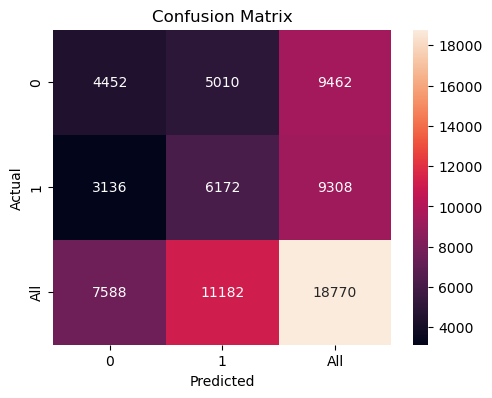

In [34]:
# Plot confusion matrix
plt.figure(figsize=(12, 9))
plt.subplot(2, 2, 1)
sns.heatmap(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True), annot=True, fmt='d')
plt.title('Confusion Matrix')

Text(0, 0.5, 'Frequency')

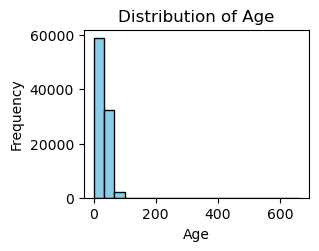

In [35]:
# Plot histogram for AGE
plt.subplot(2, 2, 2)
plt.hist(df['AGE'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

Text(0, 0.5, 'Count')

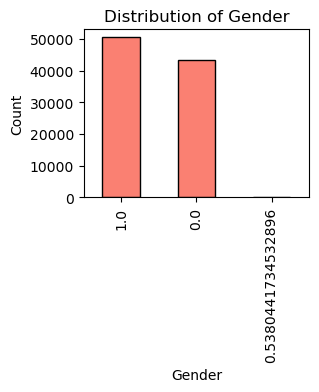

In [36]:
# Plot bar graph for GENDER
plt.subplot(2, 2, 3)
df['GENDER'].value_counts().plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

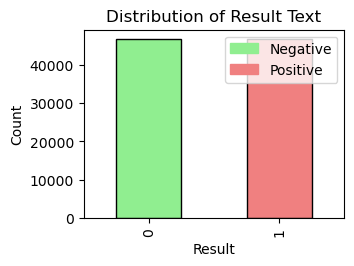

In [37]:
# Plot bar graph for RESULT_TEXT with legend
plt.subplot(2, 2, 4)
result_text_counts = df['RESULT_TEXT'].value_counts()
ax = result_text_counts.plot(kind='bar', color=['lightgreen', 'lightcoral'], edgecolor='black')
plt.title('Distribution of Result Text')
plt.xlabel('Result')
plt.ylabel('Count')

# Add legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in ['lightgreen', 'lightcoral']]
labels = ['Negative', f'Positive']
plt.legend(handles, labels)

plt.tight_layout()
plt.show()